This notebook performs evaluation on adaptive adversarial samples created from attack on noth integrated gradient and model.

In [1]:
import os
import numpy as np
import torch 
import torch.nn as nn
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt 
import numpy as np 
from captum.attr import *
import quantus
import gc

In [2]:
data_path = '/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/adaptive_attack_images_cifar/srelu/attack both ig and model/16255.npz' 

In [3]:
npobj = np.load(data_path)

In [4]:
use_cuda=True
device = torch.device("cuda" if use_cuda else "cpu")

In [5]:
keys = npobj.files
print(keys)

['adaptive_images', 'adaptive_labels', 'benign_images', 'benign_labels', 'pgd_images', 'pgd_labels']


In [6]:
npobj = np.load(data_path)
adaptive_image = npobj['adaptive_images']
adaptive_label = npobj['adaptive_labels']
ben_image = npobj['benign_images']
ben_label = npobj['benign_labels']
pgd_image = npobj['pgd_images']
pgd_label =npobj['pgd_labels']

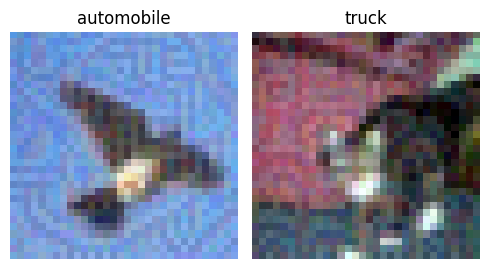

In [8]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(adaptive_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = adaptive_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

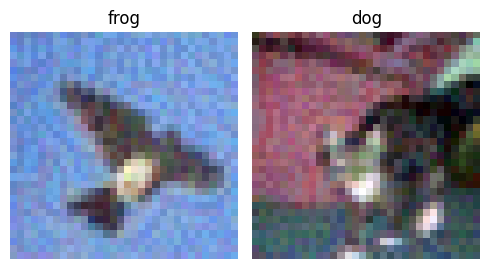

In [9]:
# Define the class names for CIFAR
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    # Access the image and label at the current index
    image = np.transpose(pgd_image[i], (1, 2, 0))  # Transpose to (height, width, channels)
    label = pgd_label[i]

    # Plot the image
    ax.imshow(image)
    ax.set_title(class_names[label])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
#load cifar model
from util.model_utils2 import resnet50

def load_model(path):
    model = resnet50()
    ckpt_dict = torch.load(path, lambda storage, loc: storage)
    model.load_state_dict(ckpt_dict)
    model.to('cuda')
    model.train(False)
    return model

modelpath = "/data/virtual environments/adv detection by robustness/adv_detection/Adaptive attacks/Models/CIFAR10/resnet50/cifar.ckpt"
model = load_model(modelpath)
model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

# IoU measure

In [11]:

def calculate_iou_score(map1, map2, threshold=0.0):
    # Apply threshold binarization
    binarized_map1 = (map1 >= threshold).astype(np.uint8)
    binarized_map2 = (map2 >= threshold).astype(np.uint8)

    # Calculate the intersection and union
    intersection = np.logical_and(binarized_map1, binarized_map2)
    union = np.logical_or(binarized_map1, binarized_map2)

    # Calculate the IoU score
    iou_score = np.sum(intersection) / np.sum(union)

    return iou_score

In [12]:
# do in a loop
i=0
th=-0.01
pgd_score=[]
adap_score=[]
for i in range(0, 100, 2):
    images, labels = torch.from_numpy(ben_image), torch.from_numpy(ben_label)
    images, labels = images.to(device), labels.to(device)
    images, labels = images[i:i+2], labels[i:i+2]
    intgrad1 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

    gc.collect()
    torch.cuda.empty_cache()
    images, labels = torch.from_numpy(pgd_image), torch.from_numpy(pgd_label)
    images, labels = images.to(device), labels.to(device)
    images, labels = images[i:i+2], labels[i:i+2]
    intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

    
    gc.collect()
    torch.cuda.empty_cache()
    #compute adaptive attack images attribution 
    images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
    images, labels = images.to(device), labels.to(device)
    images, labels = images[i:i+2], labels[i:i+2]
    intgrad3 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())
    
    gc.collect()
    torch.cuda.empty_cache()
    for j in range(len(intgrad1)):
        map1 = (intgrad1[j])
        map2 = (intgrad2[j])
        map3 = (intgrad3[j])
        iou1 = calculate_iou_score(map1, map2, threshold=th)
        iou2 = calculate_iou_score(map1, map3, threshold=th)
        pgd_score.append(iou1)
        adap_score.append(iou2)
        

print('pgd avergae iou score:', np.average(pgd_score))
print('adaptive avergae iou score:', np.average(adap_score))

pgd avergae iou score: 0.42733766341337104
adaptive avergae iou score: 0.4242820008732028


In [13]:
#compute benign attribution 
images, labels = torch.from_numpy(ben_image), torch.from_numpy(ben_label)
images, labels = images[0:5], labels[0:5]
images, labels = images.to(device), labels.to(device)
intgrad1 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

In [14]:
#compute pgd attribution 
images, labels = torch.from_numpy(pgd_image), torch.from_numpy(pgd_label)
images, labels = images[0:5], labels[0:5]
images, labels = images.to(device), labels.to(device)
intgrad2 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

In [15]:
#compute adaptive attack images attribution 
images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
images, labels = images[0:5], labels[0:5]
images, labels = images.to(device), labels.to(device)
intgrad3 = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=images, target=labels, baselines=torch.zeros_like(images)).sum(axis=1).cpu().numpy())

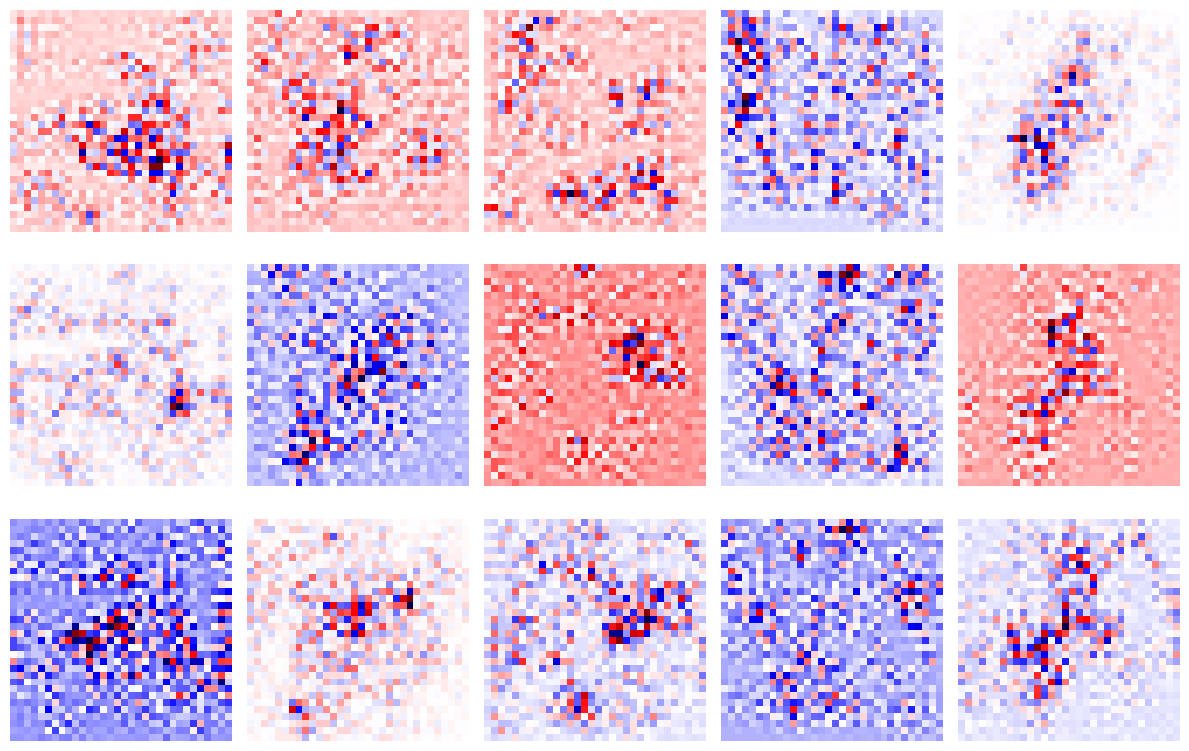

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have intgrad1, intgrad2, and intgrad3 batches of shape (15, height, width, channels)
#intgrad1 = np.random.randn(15, height, width, channels)
#intgrad2 = np.random.randn(15, height, width, channels)
#intgrad3 = np.random.randn(15, height, width, channels)

fig, axes = plt.subplots(3, 5, figsize=(12, 8))

for i, ax in enumerate(axes[0]):
    image1 = np.moveaxis((intgrad1[i]), 0, -1)
    ax.imshow(image1, cmap="seismic")
    ax.axis('off')

for i, ax in enumerate(axes[1]):
    image2 = np.moveaxis((intgrad2[i]), 0, -1)
    ax.imshow(image2, cmap="seismic")
    ax.axis('off')

for i, ax in enumerate(axes[2]):
    image3 = np.moveaxis((intgrad3[i]), 0, -1)
    ax.imshow(image3, cmap="seismic")
    ax.axis('off')

plt.tight_layout()
plt.show()


# Distortion measure

In [10]:
npobj = np.load(data_path)
adaptive_image = npobj['adaptive_images']
adaptive_label = npobj['adaptive_labels']
ben_image = npobj['benign_images']
ben_label = npobj['benign_labels']
pgd_image = npobj['pgd_images']
pgd_label =npobj['pgd_labels']

In [11]:
def calculate_distortion(image1, image2):
    
    img1 = image1.flatten().astype(float)
    img2 = image2.flatten().astype(float)
    
    score = np.linalg.norm(img1-img2)
    
    return score

In [13]:
pgd_=[]
adap =[]
for i in range(0, 80):
    img1 = adaptive_image[i]
    img2 = pgd_image[i]
    img3 = ben_image[i]

    adap.append(calculate_distortion(img1, img3))
    pgd_.append(calculate_distortion(img2, img3))
    
print(np.average(pgd_))
print(np.average(adap))

2.6277211188141023
2.6820845228047503


# Detection rate

Compute the attribution sensitivition, prediction sensitivity and input squeeze sensitivity and then report AUC based on our previous learned threshold!

In [14]:
import pandas as pd

In [21]:
def make_noise(x_batch, y_batch, spread):
    new_x_batch = []
    for x in x_batch:
        x = x.data.cpu().numpy()
        stdev = spread * (np.max(x)-np.min(x))
        noise = np.random.normal(0, stdev, x.shape).astype(np.float32)
        x_plus_noise = x + noise
        x_plus_noise = np.clip(x_plus_noise, 0, 1)
        x_plus_noise = torch.from_numpy(x_plus_noise).cpu()
        new_x_batch.append(x_plus_noise)
    new_batch = torch.stack(new_x_batch).to(device)
    return new_batch

In [22]:
normal_model = model 


In [26]:
def compute_metrics(adaptive_image, adaptive_label, normal_model): 
    
    print("Computing metrics for {} for PGD")
    
    #attribution robustness
    attribution_gaussian1 = []
    attribution_gaussian2 = []
    attribution_gaussian3 = []
    
    #logit robustness
    logit_gaussian1 = []
    logit_gaussian2 = []
    logit_gaussian3 = []
    
    images, labels = torch.from_numpy(adaptive_image), torch.from_numpy(adaptive_label)
    #images, labels = images.to(device), labels.to(device)
    
    end = len(adaptive_label)
    
    for i in range(0, end, 2):
        
        images_adv, y_pred_adv = images[i:i+2], labels[i:i+2]
        images_adv, y_pred_adv = images_adv.to(device), y_pred_adv.to(device)
        
        x_logits = normal_model(images_adv)
        gc.collect()
        torch.cuda.empty_cache()
        
        #approach: attribution and logit robustness
        a_batch = quantus.explain(
            model=normal_model, inputs=images_adv, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        gaussian_noisy_images_1 = make_noise(images_adv, y_pred_adv, spread = 0.05)
        gaussian_logits_1 = normal_model(gaussian_noisy_images_1)
        gaussian_noisy_images_2 = make_noise(images_adv, y_pred_adv, spread = 0.10)
        gaussian_logits_2 = normal_model(gaussian_noisy_images_2)
        gaussian_noisy_images_3 = make_noise(images_adv, y_pred_adv, spread = 0.15)
        gaussian_logits_3 = normal_model(gaussian_noisy_images_3)
        
        diff1 = torch.norm(x_logits-gaussian_logits_1,p=1, dim=1) 
        diff2 = torch.norm(x_logits-gaussian_logits_2,p=1, dim=1) 
        diff3 = torch.norm(x_logits-gaussian_logits_3,p=1, dim=1) 
        
        logit_gaussian1.extend(diff1.detach().cpu().numpy())
        logit_gaussian2.extend(diff2.detach().cpu().numpy())
        logit_gaussian3.extend(diff3.detach().cpu().numpy())
        
        
        a_batch_gaussian1 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_1, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian2 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_2, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        a_batch_gaussian3 = quantus.explain(
        model=normal_model, inputs=gaussian_noisy_images_3, targets=y_pred_adv, **{"method:": "IntegratedGradient", "device": device})
        
        for a, b in zip(a_batch, a_batch_gaussian1):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian1.append(c)
            
        for a, b in zip(a_batch, a_batch_gaussian2):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian2.append(c)
        
        for a, b in zip(a_batch, a_batch_gaussian3):
            c = np.linalg.norm(a.flatten()-b.flatten(),ord=1 )
            attribution_gaussian3.append(c)
        
        
    df = pd.DataFrame([
            
            attribution_gaussian1,
            attribution_gaussian2,
            attribution_gaussian3,
            logit_gaussian1,
            logit_gaussian2,
            logit_gaussian3], index = [
            "Gaussian1 attribution", 
            "Gaussian2 attribution", 
            "Gaussian3 attribution", 
            "Gaussian1 logit robusntess",
            "Gaussian2 logit robusntess",
            "Gaussian3 logit robusntess",
                    ])
            
    path = "adaptive_CIFAR_PGD.csv"
    df.to_csv(path)

In [25]:
compute_metrics(ben_image, ben_label, normal_model)

Computing metrics for {} for PGD


/data/virtual environments/adv detection by robustness/adv_detection/lib/python3.8/site-packages/quantus/functions/explanation_func.py:85: UserWarning: Using quantus 'explain' function as an explainer without specifying 'method' (string) in kwargs will produce a vanilla 'Gradient' explanation.

  warnings.warn(
/data/virtual environments/adv detection by robustness/adv_detection/lib/python3.8/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


In [28]:
compute_metrics(adaptive_image, adaptive_label, normal_model)

Computing metrics for {} for PGD


In [29]:
def compute_TPR(adv1, a, b, adv2, c, d): 
    TN=0
    FN=0
    FP = 0 
    TP=0
    
    for value1, value2 in zip(adv1, adv2): 
        if value1<a or value1>b:
            TP += 1
        else:
            if value2<c or value2>d:
                TP+=1
            else: 
                FN+=1
    
    return (TP/(TP+FN))*100

In [30]:
def compute_FPR(ap2a, k, l, ap2b, m, n): 
    TN=0
    FN=0
    FP=0 
    TP=0
    
    for value6, value7 in zip(ap2a,ap2b):
        if value6<k or value6>l:
            FP +=1
        else:
            if value7<m or value7>n:
                FP +=1

    return (FP/(len(ap2a)))*100

In [31]:
import sklearn
from sklearn.metrics import roc_auc_score

In [32]:
df_cifar = pd.read_csv("adaptive_CIFAR_Benign.csv")

In [33]:
df_cifar

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,72,73,74,75,76,77,78,79,80,81
0,Gaussian1 attribution,5846.906700,4601.549000,3881.51950,7386.488300,5812.68070,3904.146200,4499.96970,5485.51800,3724.131600,...,5225.230000,3759.262200,3534.967800,7697.22800,9098.318000,7975.359400,7479.45200,6465.358400,5517.67100,3167.370600
1,Gaussian2 attribution,4351.897500,4429.260700,3457.06320,6417.265600,4639.97660,3652.959000,3898.00500,4508.75100,3875.698200,...,5183.301000,3524.004600,3715.747800,6800.81050,7868.036600,8021.565400,5298.77640,5913.610400,4986.14300,3303.849600
2,Gaussian3 attribution,4056.605500,4229.012000,3188.26700,6291.996600,4316.92600,3257.996000,3832.86700,3923.06030,3250.289300,...,5154.963000,3324.506800,3597.120000,6705.39060,7682.964000,7639.204600,4306.36330,5307.820000,4253.33540,3138.080600
3,Gaussian1 logit robusntess,56.982640,89.992485,107.87347,60.895885,114.62748,65.969666,101.95503,63.97992,38.780080,...,38.675278,45.171577,64.581080,82.44424,94.460846,70.482056,90.24609,83.977440,69.00903,28.051039
4,Gaussian2 logit robusntess,82.079575,128.686580,161.49666,95.648445,204.01039,124.086395,137.99597,113.98193,97.157936,...,54.904950,80.134480,82.812470,114.98924,145.720610,86.911020,135.38423,105.025986,138.17151,47.144634
5,Gaussian3 logit robusntess,93.347730,120.054985,204.09189,110.327610,213.94856,151.423370,161.73431,153.89314,100.232170,...,62.152515,68.154830,79.284966,118.90502,142.849430,88.303470,165.64917,154.746920,146.87727,59.536700


In [34]:
attr_gaussian3 = df_cifar.iloc[2].values.flatten().tolist()[1:]
logit_gaussian3 = df_cifar.iloc[5].values.flatten().tolist()[1:]

In [35]:
#logitgaussian3
k=[44,64,76, 86, 96, 106, 126, 150, 200, 400]
l=[405,405,405,405,405,405,405,405,405,405, 405]

#attrgaussian3
m=[2200,2800,3100, 3500, 4000, 4500, 5000, 5500, 6000, 8000]
n=[8800,8800,8800, 8800,8800,8800, 8800,8800,8800, 8800]

fpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    FPR = compute_FPR(logit_gaussian3, t1,t2, attr_gaussian3,t3,t4)
    fpr_results.append(FPR/100)
print(fpr_results)

[0.04878048780487805, 0.13414634146341464, 0.2804878048780488, 0.4146341463414634, 0.5853658536585366, 0.7682926829268293, 0.9024390243902439, 1.0, 1.0, 1.0]


In [36]:
df_pgd_eps1 = pd.read_csv("adaptive_CIFAR_PGD.csv")

In [37]:
attr_gaussian3_eps1 = df_pgd_eps1.iloc[2].values.flatten().tolist()[1:]
logit_gaussian3_eps1 = df_pgd_eps1.iloc[5].values.flatten().tolist()[1:]

In [38]:
tpr_results =[]
for t1,t2,t3,t4 in zip(k,l,m,n):
    TPR = compute_TPR(logit_gaussian3_eps1, t1,t2, attr_gaussian3_eps1,t3,t4)
    tpr_results.append(TPR/100)
print(sklearn.metrics.auc(fpr_results, tpr_results))

0.690957763236169
